In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import lmfit as lm
from scipy import stats
from scipy import integrate

In [3]:
import guidata
_app = guidata.qapplication() # not required if a QApplication has already been created

import guidata.dataset.datatypes as dt
import guidata.dataset.dataitems as di

In [4]:
import nibabel

c:\users\neh69\appdata\local\continuum\anaconda3\envs\py36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [104]:
from epg import cpmg_epg as cpmg_epg_c

In [5]:
%matplotlib inline

In [6]:
def  epg_grad(FpFmZ, noadd=0):
#     if noadd == 0:
#         FpFmZ = np.concatenate((FpFmZ,np.zeros((3,1))), axis=1)
        
    FpFmZ[0,:] = np.roll(FpFmZ[0,:], 1)
    FpFmZ[1,:] = np.roll(FpFmZ[1,:],-1)
    FpFmZ[1,-1] = 0
    FpFmZ[0,0] = np.conjugate(FpFmZ[1,0])
    
    return(FpFmZ)
    
  
def epg_grelax( FpFmZ, T1, T2, T, kg = 0, D = 0, Gon = 1, noadd = 0):
    
    E1 = np.exp(-T/T1)
    E2 = np.exp(-T/T2)
    
    EE = np.diag([E2, E2, E1])
    RR = 1.0-E1
    
    FpFmZ = np.dot( EE, FpFmZ)
    
    FpFmZ[2,0] = FpFmZ[2,0]+RR
    
#     print(EE)
#     print('RR=',RR)
#     print('FpFmZ=\n',FpFmZ[:,:4].real)
    
    ##Assume Gradient is on and kg >= 0
    
    FpFmZ = epg_grad(FpFmZ, noadd)
    
    
    return(FpFmZ)


def  epg_rf( FpFmZ, alpha, phi ):
    
    RR = np.zeros((3,3), dtype = np.complex128)
    
    RR[0,0] = np.cos(alpha/2.)**2
    RR[0,1] = np.exp(2.0*1j*phi)*(np.sin(alpha/2.0))**2
    RR[0,2] = -1j*np.exp(1j*phi)*np.sin(alpha)
    
    RR[1,0] = np.exp(-2j*phi)*(np.sin(alpha/2.0))**2
    RR[1,1] = (np.cos(alpha/2.0))**2
    RR[1,2] = 1j*np.exp(-1j*phi)*np.sin(alpha)
    
    RR[2,0] = (-1j/2.0)*np.exp(-1j*phi)*np.sin(alpha)
    RR[2,1] = ( 1j/2.0)*np.exp( 1j*phi)*np.sin(alpha)
    RR[2,2] = np.cos(alpha)
    
    FpFmZ = np.dot(RR, FpFmZ)
    
    return( FpFmZ, RR)


def  rf_pulse( alpha, phi ):
    """alpha = rotation angle in radians
       phi   = phase angle in radians"""
    
    RR = np.zeros((3,3), dtype = np.complex128)
    
    RR[0,0] = np.cos(alpha/2.)**2
    RR[0,1] = np.exp(2.0*1j*phi)*(np.sin(alpha/2.0))**2
    RR[0,2] = -1j*np.exp(1j*phi)*np.sin(alpha)
    
    RR[1,0] = np.exp(-2j*phi)*(np.sin(alpha/2.0))**2
    RR[1,1] = (np.cos(alpha/2.0))**2
    RR[1,2] = 1j*np.exp(-1j*phi)*np.sin(alpha)
    
    RR[2,0] = (-1j/2.0)*np.exp(-1j*phi)*np.sin(alpha)
    RR[2,1] = ( 1j/2.0)*np.exp( 1j*phi)*np.sin(alpha)
    RR[2,2] = np.cos(alpha)

    
    return(RR)


def cpmg_epg_py( Nechos=17, rf_180=120.0, T1=3000.0, T2=50.0, Techo=10.0 ):
	

    P = np.zeros((3,2*Nechos),dtype=np.complex128)
    
    P[0,0] = 0.0  # Fp
    P[1,0] = 0.0  # Fm
    P[2,0] = 1.0  # Z
    
    signal = np.zeros(Nechos)
    
    rf_pulse90_rad = np.pi*rf_180/360.
    #rf_pulse90_rad = np.pi/2.0
    rf_pulse_rad = np.pi*rf_180/180.
    
    RR90  = rf_pulse(rf_pulse90_rad, np.pi/2.0)
    RR180 = rf_pulse(rf_pulse_rad,   0.0)
    
    P = np.dot( RR90, P )
    #signal[0] = P[0,0].real
    
    for echo in range(Nechos):
        P = epg_grelax( P, T1, T2, Techo/2.0)
        P = np.dot(RR180,P)
        P = epg_grelax( P, T1, T2, Techo/2.0)
        
        signal[echo] = (P[0,0].real)
        
    return(signal)


def cpmg_epg_py90_180( Nechos=17, rf_90=90.0, rf_180=120.0, T1=3000.0, T2=50.0, Techo=10.0 ):
	

    P = np.zeros((3,2*Nechos),dtype=np.complex128)
    
    P[0,0] = 0.0  # Fp
    P[1,0] = 0.0  # Fm
    P[2,0] = 1.0  # Z
    
    signal = np.zeros(Nechos)
    
    rf_pulse90_rad = np.pi*rf_90/180.
    #rf_pulse90_rad = np.pi/2.0
    rf_pulse_rad = np.pi*rf_180/180.
    
    RR90  = rf_pulse(rf_pulse90_rad, np.pi/2.0)
    RR180 = rf_pulse(rf_pulse_rad,   0.0)
    
    P = np.dot( RR90, P )
    #signal[0] = P[0,0].real
    
    for echo in range(Nechos):
        P = epg_grelax( P, T1, T2, Techo/2.0)
        P = np.dot(RR180,P)
        P = epg_grelax( P, T1, T2, Techo/2.0)
        
        signal[echo] = (P[0,0].real)
        
    return(signal)

In [7]:
class workingDirectories(dt.DataSet):
    """Set working processed directory"""
    #/media/eric/70DA58715E6C32A6/visionDMD/processed_data/newcastle_test
    #procDatadir = di.DirectoryItem("Processed Data Directory", 'W:/processed_data/Newcastle_test')
    procDatadir = di.DirectoryItem("Processed Data Directory", '/media/eric/70DA58715E6C32A6/visionDMD/processed_data/newcastle_test')


In [8]:
wDirs = workingDirectories()

In [9]:
#wDirs.edit()

In [10]:
image_filename = r"W:\processed_data\Newcastle_test\2801LW_H_01aug2017\WIP_T2_multiecho_UL_CLEAR.img"

In [11]:
#hdr = nibabel.load(filename_hdr)
img = nibabel.load(image_filename)
    
imageDataT2 = img.get_data()
imageDataT2.shape

(256, 256, 5, 17)

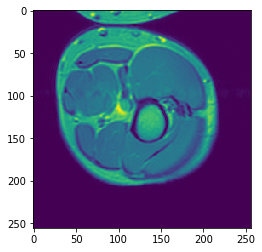

In [12]:
plt.imshow(imageDataT2[:,:,0,0]);

In [13]:
muscle_data = imageDataT2[150,175,2,:]
muscle_data = imageDataT2[60,130,2,:]
marrow_data = imageDataT2[130,140,2,:]
fat_data    = imageDataT2[40,100,2,:]

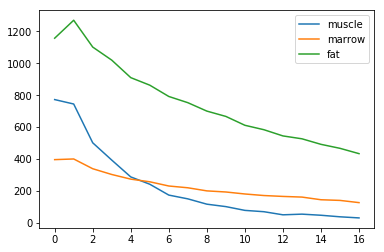

In [14]:
plt.plot(muscle_data, label='muscle');
plt.plot(marrow_data, label='marrow');
plt.plot(fat_data,    label='fat'   );
plt.legend();

In [15]:
yyy_muscle =  muscle_data/muscle_data.max()
yyy_marrow =  marrow_data/marrow_data.max()
yyy_fat    =  fat_data/fat_data.max()

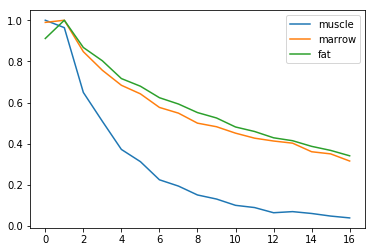

In [16]:
plt.plot(yyy_muscle, label='muscle');
plt.plot(yyy_marrow, label='marrow');
plt.plot(yyy_fat,    label='fat');
plt.legend();

In [17]:
mxyz90 = np.fromfile( 'mxyz90.txt', sep=' ' )
mxyz180 = np.fromfile('mxyz180.txt', sep=' ')

In [18]:
mxyz90 = mxyz90.reshape(5,512)
mxyz180 = mxyz180.reshape(5,512)


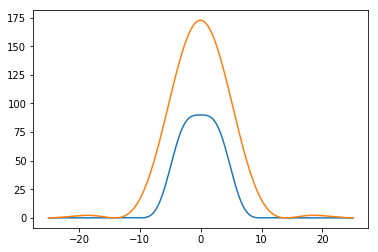

In [19]:
plt.plot(mxyz90[0],mxyz90[-1]);
plt.plot(mxyz180[0],mxyz180[-1]);

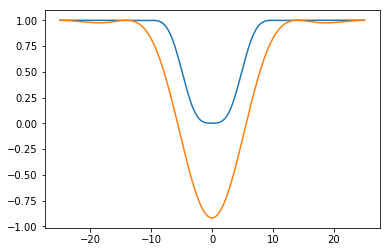

In [20]:
plt.plot(mxyz90[0],mxyz90[-2]);
plt.plot(mxyz180[0],mxyz180[-2]);

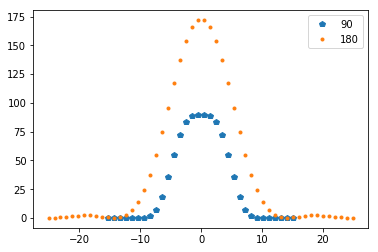

In [21]:
plt.plot(mxyz90[0][100:-100:10],mxyz90[-1][100:-100:10], 'p', label='90');
plt.plot(mxyz180[0][::10],mxyz180[-1][::10], '.', label='180');
plt.legend();

In [22]:
aaa = np.arange(10)

In [23]:
aaa

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [24]:
aaa[0:8:2]

array([0, 2, 4, 6])

In [25]:
FpFmZ = np.array([0,0,1])

In [26]:
FpFmZ = (np.zeros(3*512, dtype=np.complex128)).reshape(512,3)

In [27]:
for i,r90 in enumerate(mxyz90[-1]):
    
     FpFmZ[i] = rf_pulse( r90 * np.pi/180., np.pi/2) @ np.array([0,0,1])
    

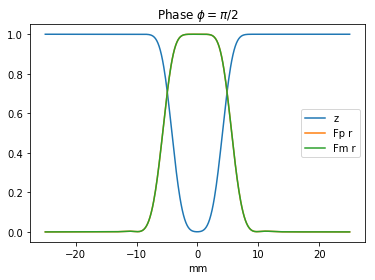

In [28]:
plt.plot( mxyz90[0], FpFmZ[:,2].real, label='z' );
plt.plot( mxyz90[0], FpFmZ[:,1].real, label='Fp r');
plt.plot( mxyz90[0], FpFmZ[:,0].real, label='Fm r' );
plt.xlabel('mm')
plt.title('Phase $\phi = \pi/2$');
plt.legend();

In [29]:
rf_pulse(np.pi/2,np.pi/2) @ np.array([0,0,1])

array([1.000000e+00-6.123234e-17j, 1.000000e+00+6.123234e-17j,
       6.123234e-17+0.000000e+00j])

In [30]:
for i,r90 in enumerate(mxyz90[-1]):
    
     FpFmZ[i] = rf_pulse( r90 * np.pi/180., 0) @ np.array([0,0,1])

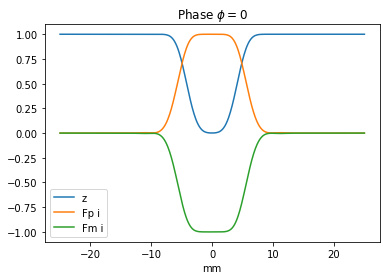

In [31]:
plt.plot( mxyz90[0], FpFmZ[:,2].real, label='z' );
plt.plot( mxyz90[0], FpFmZ[:,1].imag, label='Fp i');
plt.plot( mxyz90[0], FpFmZ[:,0].imag, label='Fm i' );
plt.title('Phase $\phi = 0$');
plt.xlabel('mm');
plt.legend();
         

In [32]:
#cpmg_epg_py90_180( Nechos=17, rf_90=90.0, rf_180=120.0, T1=3000.0, T2=50.0, Techo=10.0 )
signal =cpmg_epg_py90_180( rf_90=90.0, rf_180=180.0)

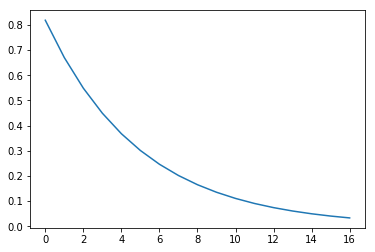

In [33]:
plt.plot(signal)

In [34]:
signal = np.zeros(17)
offset=200
for i in range(offset,512-offset):
    
    p90 = mxyz90[-1][i]
    p180 = mxyz180[-1][i]
    
    signal += cpmg_epg_py90_180( rf_90=p90, rf_180=p180)

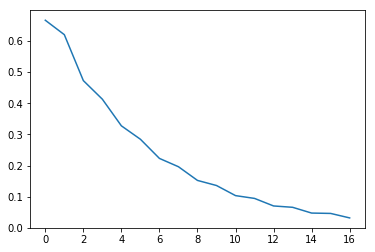

In [35]:
plt.plot(signal/(512.-2*offset));

In [36]:
def fit_cpmg_epg_muscle_philips_hargreaves_py( params,  xxx,  p90_array, p180_array, yyy_exp=None):
    
    parvals  = params.valuesdict()
    

    
    T1fat    = parvals[ 'T1fat' ]      # fixed
    T1muscle = parvals[ 'T1muscle' ]      # fixed
    echo     = parvals[ 'echo' ]     # fixed
    b1_scale = parvals['b1_scale']   # optimized
    T2fat    = parvals[ 'T2fat' ]     # fixed
    T2muscle = parvals['T2muscle']       # optimized
    Afat     = parvals[ 'Afat']       # optimized
    Amuscle = parvals['Amuscle']        # optimized
    
    Nechos = len(xxx)
    Ngauss = len(p90_array)
    signal = np.zeros([Ngauss,Nechos])
    
    
    for i,(p90,p180) in enumerate(zip(p90_array,p180_array)):
        #print(i,g, pi_pulse*g)
        signal[i]  = Afat*cpmg_epg_py90_180( Nechos=Nechos, rf_180=p180*b1_scale, rf_90=p90*b1_scale, T1=T1fat, T2=T2fat, Techo=echo )
        signal[i] += Amuscle*cpmg_epg_py90_180( Nechos=Nechos, rf_180=p180*b1_scale, rf_90=p90*b1_scale, T1=T1muscle, T2=T2muscle, Techo=echo )
    
    int_signal = integrate.simps(signal, dx=1./(Ngauss-1),axis=0)
    if isinstance(yyy_exp, np.ndarray):   
        return( int_signal-yyy_exp)
    else:
        return(int_signal,signal) 

In [107]:
def fit_cpmg_epg_muscle_philips_hargreaves_c( params,  xxx,  p90_array, p180_array, yyy_exp=None):
    
    parvals  = params.valuesdict()
    

    
    T1fat    = parvals[ 'T1fat' ]      # fixed
    T1muscle = parvals[ 'T1muscle' ]      # fixed
    echo     = parvals[ 'echo' ]     # fixed
    b1_scale = parvals['b1_scale']   # optimized
    T2fat    = parvals[ 'T2fat' ]     # fixed
    T2muscle = parvals['T2muscle']       # optimized
    Afat     = parvals[ 'Afat']       # optimized
    Amuscle = parvals['Amuscle']        # optimized
    
    Nechos = len(xxx)
    Ngauss = len(p90_array)
    signal = np.zeros([Ngauss,Nechos])
    signal1 = np.zeros(Nechos)
    signal2 = np.zeros(Nechos)
    
    for i,(p90,p180) in enumerate(zip(p90_array,p180_array)):
        #print(i,g, pi_pulse*g)
        cpmg_epg_c( signal1, p90*b1_scale, p180*b1_scale, T1fat,    T2fat,    echo )
        cpmg_epg_c( signal2, p90*b1_scale, p180*b1_scale, T1muscle, T2muscle, echo )
        signal[i] = Afat*signal1+Amuscle*signal2
        
    int_signal = integrate.simps(signal, dx=1./(Ngauss-1),axis=0)
    if isinstance(yyy_exp, np.ndarray):   
        return( int_signal-yyy_exp)
    else:
        return(int_signal,signal) 

In [108]:
params = lm.Parameters()
params.add('b1_scale',   value= 1.0,  min=0, max=5.0, vary=True)
params.add('T2fat', value = 180.0, min=0, max=1000, vary=True)
params.add('T2muscle', value = 35, min=0, max=1000, vary=True)
params.add('Afat', value = 0.5,  min=0, max=10, vary=True)
params.add('Amuscle', value = 3,  min=0, max=10, vary=True)
params.add('T1fat', value = 365.0, vary=False)
params.add('T1muscle', value = 1400, vary=False)
params.add('echo', value = 10.0, vary=False)

In [109]:
offset=130
step=5
slice_xxx =mxyz90[0][offset:-offset+step:step] # mm
p90 = mxyz90[-1][offset:-offset+step:step]     # degrees
p180 = mxyz180[-1][offset:-offset+step:step]   # degrees

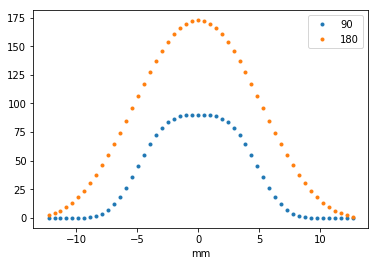

In [110]:
plt.plot( slice_xxx, p90, '.', label='90');
plt.plot( slice_xxx, p180, '.', label='180');
plt.xlabel('mm');
plt.legend();

In [119]:
xxx = np.linspace(10,170,17)
(s1,s2) =fit_cpmg_epg_muscle_philips_hargreaves_py( params,  xxx,  [90,90,90], [160,160,160])
(c1,c2) =fit_cpmg_epg_muscle_philips_hargreaves_c( params,  xxx,  [90,90,90], [160,160,160])

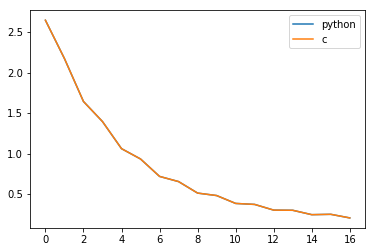

In [120]:
plt.plot(s1, label='python');
plt.plot(c1, label='c');
plt.legend()

In [121]:
(s1,s2) =fit_cpmg_epg_muscle_philips_hargreaves_c( params,  xxx,  p90, p180)

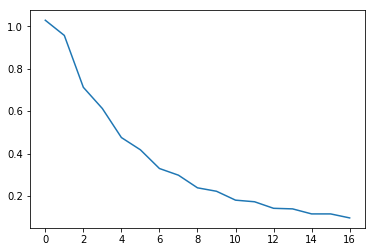

In [122]:
plt.plot(s1);

In [123]:
xxx

array([ 10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100., 110.,
       120., 130., 140., 150., 160., 170.])

In [125]:
minner = lm.Minimizer(fit_cpmg_epg_muscle_philips_hargreaves_c, params, fcn_args=( xxx,  p90, p180, yyy_muscle))



In [126]:
result = minner.minimize()

In [127]:
result.params.valuesdict()

OrderedDict([('b1_scale', 0.9018989819779379),
             ('T2fat', 300.96843893024516),
             ('T2muscle', 29.749394744494783),
             ('Afat', 0.14450226279030476),
             ('Amuscle', 4.021130918015866),
             ('T1fat', 365.0),
             ('T1muscle', 1400),
             ('echo', 10.0)])

In [130]:
(r1,r2) = fit_cpmg_epg_muscle_philips_hargreaves_c( result.params,  xxx,  p90, p180)

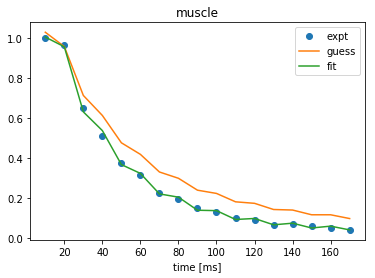

In [131]:
plt.plot(xxx,yyy_muscle,'o', label='expt');
plt.plot(xxx,s1,'-', label='guess');
plt.plot(xxx,r1,'-', label='fit');
plt.title('muscle');
plt.xlabel('time [ms]')
plt.legend();

In [132]:
fit_params = result.params

In [133]:
fit_values = fit_params.valuesdict()

In [134]:
fit_values['Amuscle']*100/(fit_values['Amuscle']+fit_values['Afat'])

96.53108527519603

In [135]:
fit_values

OrderedDict([('b1_scale', 0.9018989819779379),
             ('T2fat', 300.96843893024516),
             ('T2muscle', 29.749394744494783),
             ('Afat', 0.14450226279030476),
             ('Amuscle', 4.021130918015866),
             ('T1fat', 365.0),
             ('T1muscle', 1400),
             ('echo', 10.0)])

In [136]:
print(dir(lm))

['CompositeModel', 'Minimizer', 'MinimizerException', 'Model', 'Parameter', 'Parameters', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', '_version', 'asteval', 'astutils', 'ci_report', 'conf_interval', 'conf_interval2d', 'confidence', 'correlated_values', 'fit_report', 'lineshapes', 'minimize', 'minimizer', 'model', 'models', 'parameter', 'printfuncs', 'report_ci', 'report_errors', 'report_fit', 'sys', 'ufloat', 'uncertainties']


In [137]:
lm.report_fit(fit_params)

[[Variables]]
    b1_scale:   0.90189898 +/- 0.023712 (2.63%) (init= 1)
    T2fat:      300.968438 +/- 1.01e+03 (335.07%) (init= 180)
    T2muscle:   29.7493947 +/- 2.761278 (9.28%) (init= 35)
    Afat:       0.14450226 +/- 0.241503 (167.13%) (init= 0.5)
    Amuscle:    4.02113091 +/- 0.201707 (5.02%) (init= 3)
    T1fat:      365 (fixed)
    T1muscle:   1400 (fixed)
    echo:       10 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(T2fat, Afat)               = -0.992 
    C(T2muscle, Afat)            = -0.949 
    C(T2fat, T2muscle)           =  0.917 
    C(T2fat, Amuscle)            =  0.686 
    C(Afat, Amuscle)             = -0.655 
    C(b1_scale, T2muscle)        =  0.478 
    C(b1_scale, Amuscle)         = -0.451 
    C(T2muscle, Amuscle)         =  0.420 
    C(b1_scale, Afat)            = -0.306 
    C(b1_scale, T2fat)           =  0.277 


In [138]:
params = lm.Parameters()
params.add('b1_scale',   value= 0.8,  min=0, max=5.0, vary=True)
params.add('T2fat', value = 180.0, min=0, max=1000, vary=True)
params.add('T2muscle', value = 35, min=0, max=1000, vary=True)
params.add('Afat', value = 6,  min=0, max=10, vary=True)
params.add('Amuscle', value = 0.5,  min=0, max=10, vary=True)
params.add('T1fat', value = 365.0, vary=False)
params.add('T1muscle', value = 1400, vary=False)
params.add('echo', value = 10.0, vary=False)

In [139]:
minner = lm.Minimizer(fit_cpmg_epg_muscle_philips_hargreaves_c, params, fcn_args=( xxx, p90, p180, yyy_marrow))

In [140]:
result = minner.minimize()

In [141]:
result.params.valuesdict()

OrderedDict([('b1_scale', 0.9927015427911947),
             ('T2fat', 213.5544787659946),
             ('T2muscle', 30.74776630553322),
             ('Afat', 1.7277371042318912),
             ('Amuscle', 1.3917403178024401),
             ('T1fat', 365.0),
             ('T1muscle', 1400),
             ('echo', 10.0)])

In [142]:
(r1,r2) = fit_cpmg_epg_muscle_philips_hargreaves_py( result.params,  xxx, p90, p180)

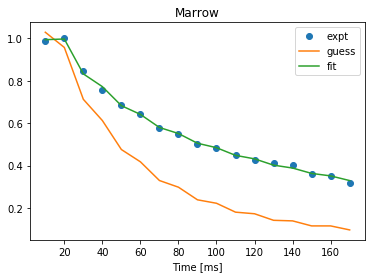

In [143]:
plt.plot(xxx,yyy_marrow,'o', label='expt');
plt.plot(xxx,s1,'-', label='guess');
plt.plot(xxx,r1,'-', label='fit');
plt.title('Marrow');
plt.xlabel('Time [ms]')
plt.legend();

In [144]:
fit_params = result.params
fit_values = fit_params.valuesdict()
fit_values['Amuscle']*100/(fit_values['Amuscle']+fit_values['Afat'])

44.61453408740598

In [145]:
lm.report_fit(fit_params)

[[Variables]]
    b1_scale:   0.99270154 +/- 0.030000 (3.02%) (init= 0.8)
    T2fat:      213.554478 +/- 34.77170 (16.28%) (init= 180)
    T2muscle:   30.7477663 +/- 5.903249 (19.20%) (init= 35)
    Afat:       1.72773710 +/- 0.218248 (12.63%) (init= 6)
    Amuscle:    1.39174031 +/- 0.158114 (11.36%) (init= 0.5)
    T1fat:      365 (fixed)
    T1muscle:   1400 (fixed)
    echo:       10 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(T2fat, Afat)               = -0.980 
    C(T2muscle, Afat)            = -0.972 
    C(T2fat, T2muscle)           =  0.937 
    C(T2fat, Amuscle)            =  0.906 
    C(Afat, Amuscle)             = -0.830 
    C(T2muscle, Amuscle)         =  0.761 
    C(b1_scale, Afat)            = -0.467 
    C(b1_scale, T2muscle)        =  0.440 
    C(b1_scale, T2fat)           =  0.316 


In [147]:
minner = lm.Minimizer(fit_cpmg_epg_muscle_philips_hargreaves_c, params, fcn_args=( xxx,  p90, p180, yyy_fat))

In [148]:
result = minner.minimize()

In [149]:
result.params.valuesdict()

OrderedDict([('b1_scale', 0.8909340746573045),
             ('T2fat', 199.8290417851527),
             ('T2muscle', 41.23613739970678),
             ('Afat', 2.0176434538442),
             ('Amuscle', 1.1069266559359037),
             ('T1fat', 365.0),
             ('T1muscle', 1400),
             ('echo', 10.0)])

In [150]:
(r1,r2) = fit_cpmg_epg_muscle_philips_hargreaves_py( result.params,  xxx,  p90, p180)

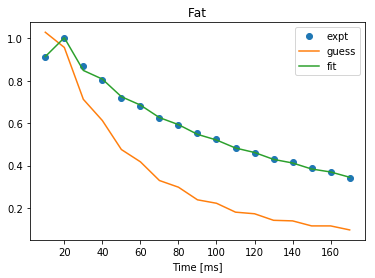

In [151]:
plt.plot(xxx,yyy_fat,'o', label='expt');
plt.plot(xxx,s1,'-', label='guess');
plt.plot(xxx,r1,'-', label='fit');
plt.title('Fat');
plt.xlabel('Time [ms]')
plt.legend();

In [152]:
fit_params = result.params
fit_values = fit_params.valuesdict()
fit_values['Amuscle']*100/(fit_values['Amuscle']+fit_values['Afat'])

35.42652643546556

In [153]:
lm.report_fit(fit_params)

[[Variables]]
    b1_scale:   0.89093407 +/- 0.017379 (1.95%) (init= 0.8)
    T2fat:      199.829041 +/- 45.76352 (22.90%) (init= 180)
    T2muscle:   41.2361374 +/- 13.83994 (33.56%) (init= 35)
    Afat:       2.01764345 +/- 0.448438 (22.23%) (init= 6)
    Amuscle:    1.10692665 +/- 0.384344 (34.72%) (init= 0.5)
    T1fat:      365 (fixed)
    T1muscle:   1400 (fixed)
    echo:       10 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(T2fat, Afat)               = -0.993 
    C(T2fat, Amuscle)            =  0.993 
    C(T2muscle, Afat)            = -0.989 
    C(Afat, Amuscle)             = -0.982 
    C(T2fat, T2muscle)           =  0.972 
    C(T2muscle, Amuscle)         =  0.961 
    C(b1_scale, T2muscle)        =  0.482 
    C(b1_scale, Afat)            = -0.481 
    C(b1_scale, T2fat)           =  0.405 
    C(b1_scale, Amuscle)         =  0.320 
